In [2]:
import sys
sys.path.append('../')
from mss import visreader as mvis
from mss import mssmain as msm
import pandas as pd
import numpy as np

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

import seaborn as sns
import peakutils
import scipy
from scipy.integrate import simps
import itertools

In [2]:
path = 'D:/UW/mssvalidation/20201119_ENTACT_validation_data/20201117_ENTACT_506_1.mzML'
scans = msm.get_scans(path, ms_all=False, ms_lv=1)
#noise removal
msm.noise_removal(scans, 2000)

In [2]:
manual = pd.read_csv('D:/UW/mssvalidation/20201119_ENTACT_validation_data/506_minscan5.csv')

In [12]:
h_range = 3
intensity=[1,2,3,4,5,4,3,2,1]
x = np.linspace(h_range - 2, h_range, 3)
y = intensity[h_range - 2: h_range + 1]

In [31]:
int(0.5 / (scans[1].scan_time[0] - scans[0].scan_time[0]))

30

In [11]:
mass = 194.1182
ppm = 10
manual[(manual['m/z'] > mass - mass*ppm*1e-6) & (manual['m/z'] < mass + mass * ppm * 1e-6)]

,Unnamed: 0,m/z,rt,sn,score,peak area
3752,3752,194.119,0.63,0.858,2,762129.238607
3753,3753,194.119,3.47,0.494,3,104144.989421
3754,3754,194.119,3.73,0.802,2,192672.691406
3755,3755,194.119,4.35,1.543,2,684418.184896
3756,3756,194.119,4.79,0.806,3,93926.303385


In [9]:
test = msm.peak_pick(scans,194.1182,10,enable_score=True)

In [62]:
d_md505 = pd.read_excel('D:/UW/mssvalidation/20201119_ENTACT_validation_data/20201117_ENTACT_msdial.xlsx',sheet_name='505')

In [63]:
d_s1 = pd.read_csv('D:/UW/mssvalidation/20201119_ENTACT_validation_data/505_minscan5.csv')
d_s1_7= pd.read_csv('D:/UW/mssvalidation/20201119_ENTACT_validation_data/505.csv')

In [64]:
d_mss = d_s1[['rt', 'm/z', 'peak area']]
d_mss_7 = d_s1_7[['rt', 'm/z', 'peak area']]

In [65]:
d_msdial = d_md505[['RT (min)', 'Precursor m/z', 'Area']]

In [66]:
def batch_alignment(d_ref, d_align, rt_error=0.5, mz_error=0.01):
    #Alignment of new dataset
    result = []
    for row in np.arange(len(d_ref)):
        #Find overlap using the error range
        overlap = np.where((d_align.iloc[:, 0] - rt_error <=
                                        d_ref.iloc[row, 0]) & (d_ref.iloc[row, 0] <=
                                        d_align.iloc[:, 0] + rt_error) & (d_align.iloc[:, 1] - mz_error <=
                                        d_ref.iloc[row, 1]) & (d_ref.iloc[row, 1] <=
                                        d_align.iloc[:, 1] + mz_error))
        if len(overlap[0]) == 1:
            result.append([overlap[0][0], row])
        elif len(overlap[0]) > 1:
            dist = []
            for i in overlap[0]: # if multiple hits, use the closer feature for alignment
                dist.append(np.sqrt(((d_align.iloc[i, 0] - d_ref.iloc[row, 0])**2) +
                                    ((d_align.iloc[i, 1] - d_ref.iloc[row, 1])**2)))
            result.append([overlap[0][np.argmin(dist)], row])
        
    #Modeling using overlapping features except noises
#     align_index = [i[0] for i in result]
#     ref_index = [i[1] for i in result]
#     d_align = d_align.loc[align_index]
#     d_ref = d_ref.iloc[ref_index]

#     d_align.reset_index(drop=True,inplace=True)
#     d_ref.reset_index(drop=True,inplace=True)
#     d_join = d_align.iloc[:,3:] #Important !! -- The indexing is important especially reading other feedin data
#     d_merge = pd.concat([d_ref,d_join],axis=1)
        
    return result

In [67]:
d_xcms_raw = pd.read_excel('D:/UW/mssvalidation/20201119_ENTACT_validation_data/ENTACT505/results/XCMS-Report-SingleClass.xlsx')

In [68]:
d_xcms = d_xcms_raw[['rt', 'mz', 'into']].copy()
d_xcms['rt'] = d_xcms_raw['rt'] / 60

In [69]:
overlap_msd = batch_alignment(d_mss, d_msdial,rt_error = 0.1,mz_error=0.015)
overlap_xcms = batch_alignment(d_mss, d_xcms,rt_error = 0.1,mz_error=0.015)

In [75]:
overlap_min_scan = batch_alignment(d_mss, d_mss_7,rt_error = 0.1,mz_error=0.015)

In [34]:
len(list(set([i[1] for i in overlap_min_scan])))

NameError: name 'overlap_min_scan' is not defined

In [76]:
len(overlap_min_scan)

11727

In [77]:
d_mss_7.shape

(10928, 3)

In [70]:
mss_index_msd = [i[1] for i in overlap_msd]
mss_index_xcms = [i[1] for i in overlap_xcms]
msd_index = [i[0] for i in overlap_msd]
xcms_index = [i[0] for i in overlap_xcms]

In [81]:
len(mss_index_msd)

11532

In [82]:
len(mss_index_xcms)

11225

In [55]:
trip_overlap = batch_alignment(d_mss.iloc[mss_index_msd], d_xcms, rt_error=0.2, mz_error=0.015)
q_overlap = batch_alignment(d_msdial, d_xcms, rt_error=0.2, mz_error=0.015)

In [15]:
d_trip_overlap = d_s1.iloc[mss_index_msd].iloc[[i[1] for i in trip_overlap]].copy()
#d_trip_overlap.to_csv('D:/UW/mssvalidation/20201119_ENTACT_validation_data/export/202011247_505_alloverlap_rt02_mz0015.csv')

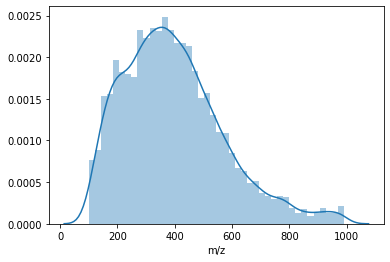

In [91]:
sns.distplot(d_trip_overlap['m/z'])

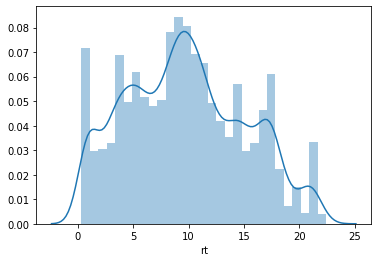

In [92]:
sns.distplot(d_trip_overlap['rt'])

In [56]:
len(trip_overlap)

8554

In [57]:
len(q_overlap)

12387

In [98]:
max(rtdist)

0.09987999999999886

(array([ 295.,  264.,  349., 1037., 4517., 3932.,  513.,  207.,  203.,
         215.]),
 array([-9.996670e-02, -7.998203e-02, -5.999736e-02, -4.001269e-02,
        -2.002802e-02, -4.335000e-05,  1.994132e-02,  3.992599e-02,
         5.991066e-02,  7.989533e-02,  9.988000e-02]),
 <a list of 10 Patch objects>)

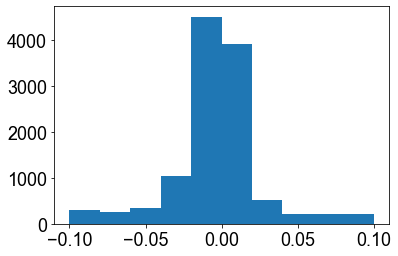

In [99]:
plt.hist(rtdist)

Text(0.5, 1.0, 'retention time difference distribution')

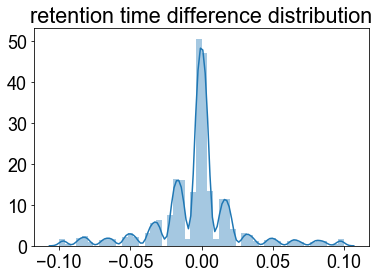

In [92]:
from scipy.stats import norm
rtdist = list(list(d_mss.loc[mss_index_msd]['rt']) - (d_msdial.loc[msd_index]['RT (min)']))
sns.distplot(rtdist)
plt.title('retention time difference distribution')

Text(0.5, 1.0, 'm/z difference distribution')

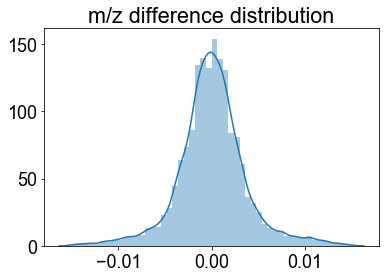

In [103]:
rtdist = list(list(d_mss.loc[mss_index_msd]['m/z']) - (d_msdial.loc[msd_index]['Precursor m/z']))
sns.distplot(rtdist)
plt.title('m/z difference distribution')

Text(0.5, 1.0, 'Peak area difference distribution')

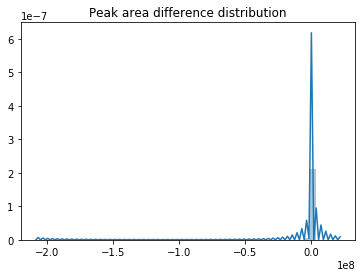

In [32]:
rtdist = list(list(d_mss.loc[mss_index]['peak area']) - (d_xcms.loc[xcms_index]['into']))
sns.distplot(rtdist)
plt.title('Peak area difference distribution')

In [58]:
d_msdial.shape[0]

18868

In [59]:
d_mss.shape[0]

20488

In [60]:
d_xcms.shape[0]

14206

In [27]:
17257-15630

1627

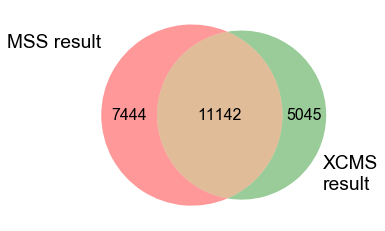

In [48]:
font1 = {'family':'serif','color':'black','size':16} # use for title
font2 = {'family': 'Arial', 'size': 16} # use for labels
plt.rc('font', **font2) # sets the default font 
vd = venn2(subsets = (18586-11142, 16187-11142, 11142), set_labels = ('MSS result', 'XCMS\nresult'))
lbl = vd.get_label_by_id("A")
x, y = lbl.get_position()
lbl.set_position((x-0.5, y+1))

lbl = vd.get_label_by_id("B")
x, y = lbl.get_position()
lbl.set_position((x+0.45, y+0.3))
#plt.title('rt_error = 0.5, mz_error = 0.015 Da')

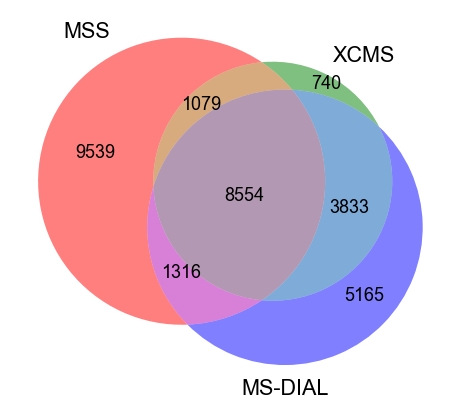

In [61]:
plt.figure(figsize = (8,8))
font1 = {'family':'serif','color':'black','size':16} # use for title
font2 = {'family': 'Arial', 'size': 18} # use for labels
plt.rc('font', **font2) # sets the default font 
venn3(subsets = (9539,740,1079,5165,1316,3833,8554), set_labels = ('MSS', 'XCMS', 'MS-DIAL'), alpha = 0.5);

In [16]:
#distribution of mass error and rt error in aligned features
#summary of peak area in unique and overlapped ones
#score assessment

In [139]:
d_xcms.loc[xcms_index]

,rt,mz,into
1548,0.625317,105.963279,146502.933261
361,0.625317,107.960023,120927.914696
312,0.625317,110.008953,470878.259287
2019,0.675067,111.010860,15122.851232
1317,0.675067,112.006249,17726.079376
...,...,...,...
5822,21.106733,165.052680,98682.191621
5819,21.139900,127.959653,191276.798619
5813,21.106733,133.026363,54454.330364
5808,21.090150,107.029921,216122.826739


Text(0.5, 1.0, 'overlap scoring')

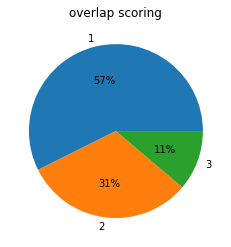

In [62]:
plt.pie(d_s1.loc[mss_index_xcms]['score'].value_counts(),labels=list(set(d_s1['score'])), autopct='%1.0f%%');
plt.title('overlap scoring')
#plt.xticks([1,2,3])

Text(0.5, 1.0, 'unique features scoring')

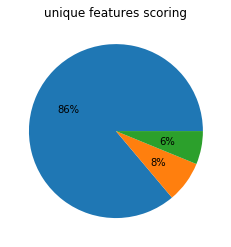

In [63]:
plt.pie(d_s1.loc[[i for i in d_s1.index if i not in mss_index_xcms]]['score'].value_counts(), autopct='%1.0f%%');
plt.title('unique features scoring')

In [44]:
d_msdial.loc[[i for i in d_msdial.index if i not in msd_index]]

,RT(min),Precursor m/z,Area
0,0.59215,105.9635,233135.70
1,0.59215,107.9599,132922.30
2,0.59215,110.0088,521536.60
3,0.59215,111.0117,82580.55
4,0.59215,112.0069,75445.54
...,...,...,...
2964,21.20623,141.9593,15008850.00
2965,21.20623,182.9832,728052.60
2966,21.27257,128.9878,644385.40
2967,21.28915,113.9649,1128074.00


In [63]:
d_mss

,rt,m/z,peak area
0,3.97,100.0113,160580.431315
1,3.06,100.0733,24689.075602
2,2.08,100.0753,53319.403320
3,2.68,100.1073,19946.666463
4,0.84,100.1113,219598.429525
...,...,...,...
10923,19.59,1679.4716,28597.217855
10924,19.57,1680.4796,13778.617269
10925,20.15,1680.4796,15459.764791
10926,20.22,1681.4545,12127.953857


In [97]:
test_dict = {1:1,2:2,3:3}
import itertools 
dict(itertools.islice(test_dict.items(), 1))  

{1: 1}

In [94]:
peak_pick(scans,299.1765,50)

{672: [664, 679, 393229.9112955729, 0, 1]}

In [136]:
d_xcms.iloc[exclude_index].iloc[3000:3200]

,rt,mz,into
6502,7.760367,395.138132,32772.443676
6510,7.760367,465.953522,15142.679954
6538,7.760367,471.222196,124869.898506
6485,7.760367,472.225516,23902.866222
6539,7.760367,484.139372,47420.893985
...,...,...,...
409,8.009017,693.184732,23638.069747
6819,8.009017,703.081262,32270.227104
6793,8.009017,708.348610,12749.728072
1349,7.992433,909.400040,49841.495182


484.139


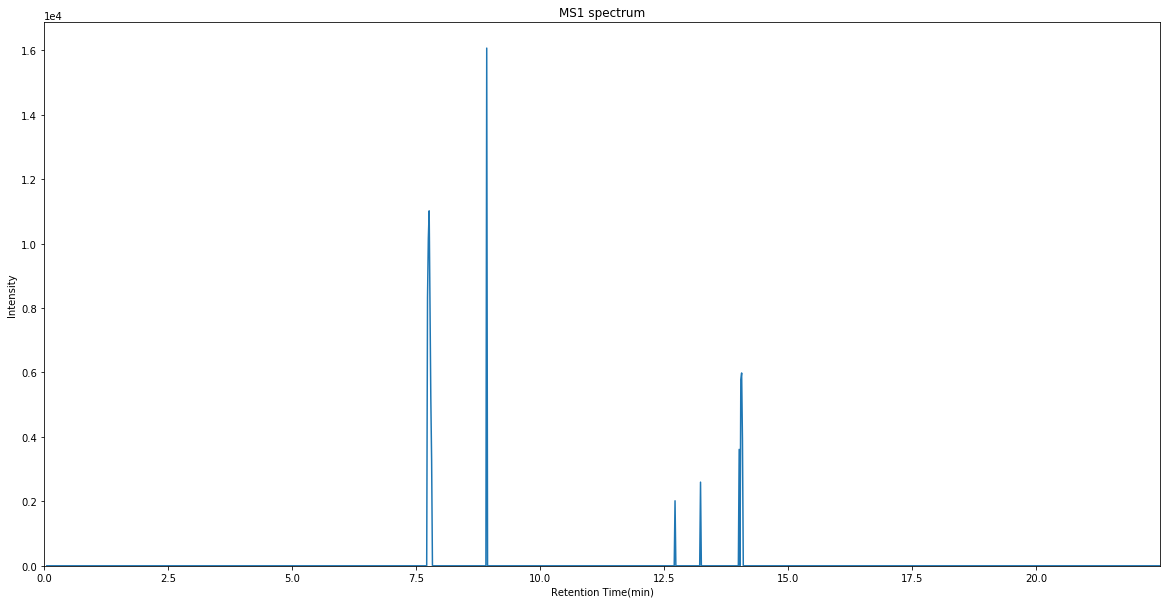

In [139]:
mss.visreader.ms_chromatogram(scans, 484.1393, 10,interactive=False)